In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [26]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,0.0,cluster0,simple,NaN


In [27]:
df.shape

(95, 44)

# add cut&tag value

In [29]:
df["celltype"].value_counts()

HBEC    41
H9D3    31
H9D0    23
Name: celltype, dtype: int64

In [43]:
gene_celltype, celltype = "HBEC", "HBEC"
gene_celltype, celltype = "H9D0",  "ESC_D0"
gene_celltype, celltype = "H9D3",  "ESC_D3"
data = df[df["celltype"]==gene_celltype]
data.shape

(31, 44)

In [44]:
# Define your files along with the corresponding score type (genebody or tss)
files = [
    f"{celltype}_ATAC_genebody.tab", f"{celltype}_ATAC_tss.tab",
    f"{celltype}_H3K27ac_genebody.tab", f"{celltype}_H3K27ac_tss.tab",
    f"{celltype}_H3K36me3_genebody.tab", f"{celltype}_H3K36me3_tss.tab",
    f"{celltype}_H3K4me1_genebody.tab", f"{celltype}_H3K4me1_tss.tab",
    f"{celltype}_H3K4me3_genebody.tab", f"{celltype}_H3K4me3_tss.tab",
    f"{celltype}_H3K9me3_genebody.tab", f"{celltype}_H3K9me3_tss.tab",
    f"{celltype}_H3K27me3_genebody.tab", f"{celltype}_H3K27me3_tss.tab"
]

# Assuming df_wan is your initial DataFrame
for file in files:
    parts = file.split('_')
    mark = parts[-2]
    #mark = '_'.join(parts[1:-1])  # e.g., H3K27ac
    region = parts[-1].split('.')[0]  # e.g., genebody or tss

    # Construct the score column name
    score_column_name = f"{mark}_{region}_mean"  # e.g., H3K27ac_genebody_mean

    # Read the file
    df_temp = pd.read_csv(f"~/projects/transcriptome_4D/data/gene_property/{file}", header=None, sep='\t',
                          names=["gene", "size", "covered", "total", "mean0", score_column_name])

    # Extract only the 'gene_full' and the score column
    df_temp = df_temp[["gene", score_column_name]]

    # Merge with df_wan
    data = pd.merge(data, df_temp, on="gene")
data.shape

(29, 58)

In [45]:
data.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment,ATAC_genebody_mean,ATAC_tss_mean,H3K27ac_genebody_mean,H3K27ac_tss_mean,H3K36me3_genebody_mean,H3K36me3_tss_mean,H3K4me1_genebody_mean,H3K4me1_tss_mean,H3K4me3_genebody_mean,H3K4me3_tss_mean,H3K9me3_genebody_mean,H3K9me3_tss_mean,H3K27me3_genebody_mean,H3K27me3_tss_mean
0,EIF4B,"[10, 30, 31, 7, 11, 17, 10, 6, 14, 15, 26, 3]","[22, 102, 19, 21, 12, 14, 55, 18, 52, 8, 44]",15.0,33.363636,0.029973,0.066667,12.5,21.0,12,11,without_TATA,without_inr,chr12,+,53006281.0,ENSG00000063046.13,-0.006,0.474,0.034,0.675,0.084,0.284,0.003,-0.017,-0.114,-0.13,0.013,0.034,0.011,0.001,0.766,chr12,53006282.0,53042215.0,+,ENSG00000063046,NaN,1.0,H9D3,1.06669,cluster1,simple,NaN,1.84726,16.5111,0.998589,14.8762,6.9701,6.98286,0.835516,10.4014,1.52268,34.3777,0.249718,0.234373,0.025921,1.06669


ATAC_tss_mean -0.66  0.3026
H3K36me3_tss_mean 0.18  0.8309
H3K27ac_tss_mean -0.91  0.0050
H3K4me1_tss_mean 0.44  0.3855
H3K4me3_tss_mean 0.50  0.0106
H3K9me3_tss_mean -9.68  0.6092
H3K27me3_tss_mean 0.06  0.0019
-0.66 0.3026 0.18 0.8309 -0.91 0.0050 0.44 0.3855 0.50 0.0106 -9.68 0.6092 0.06 0.0019


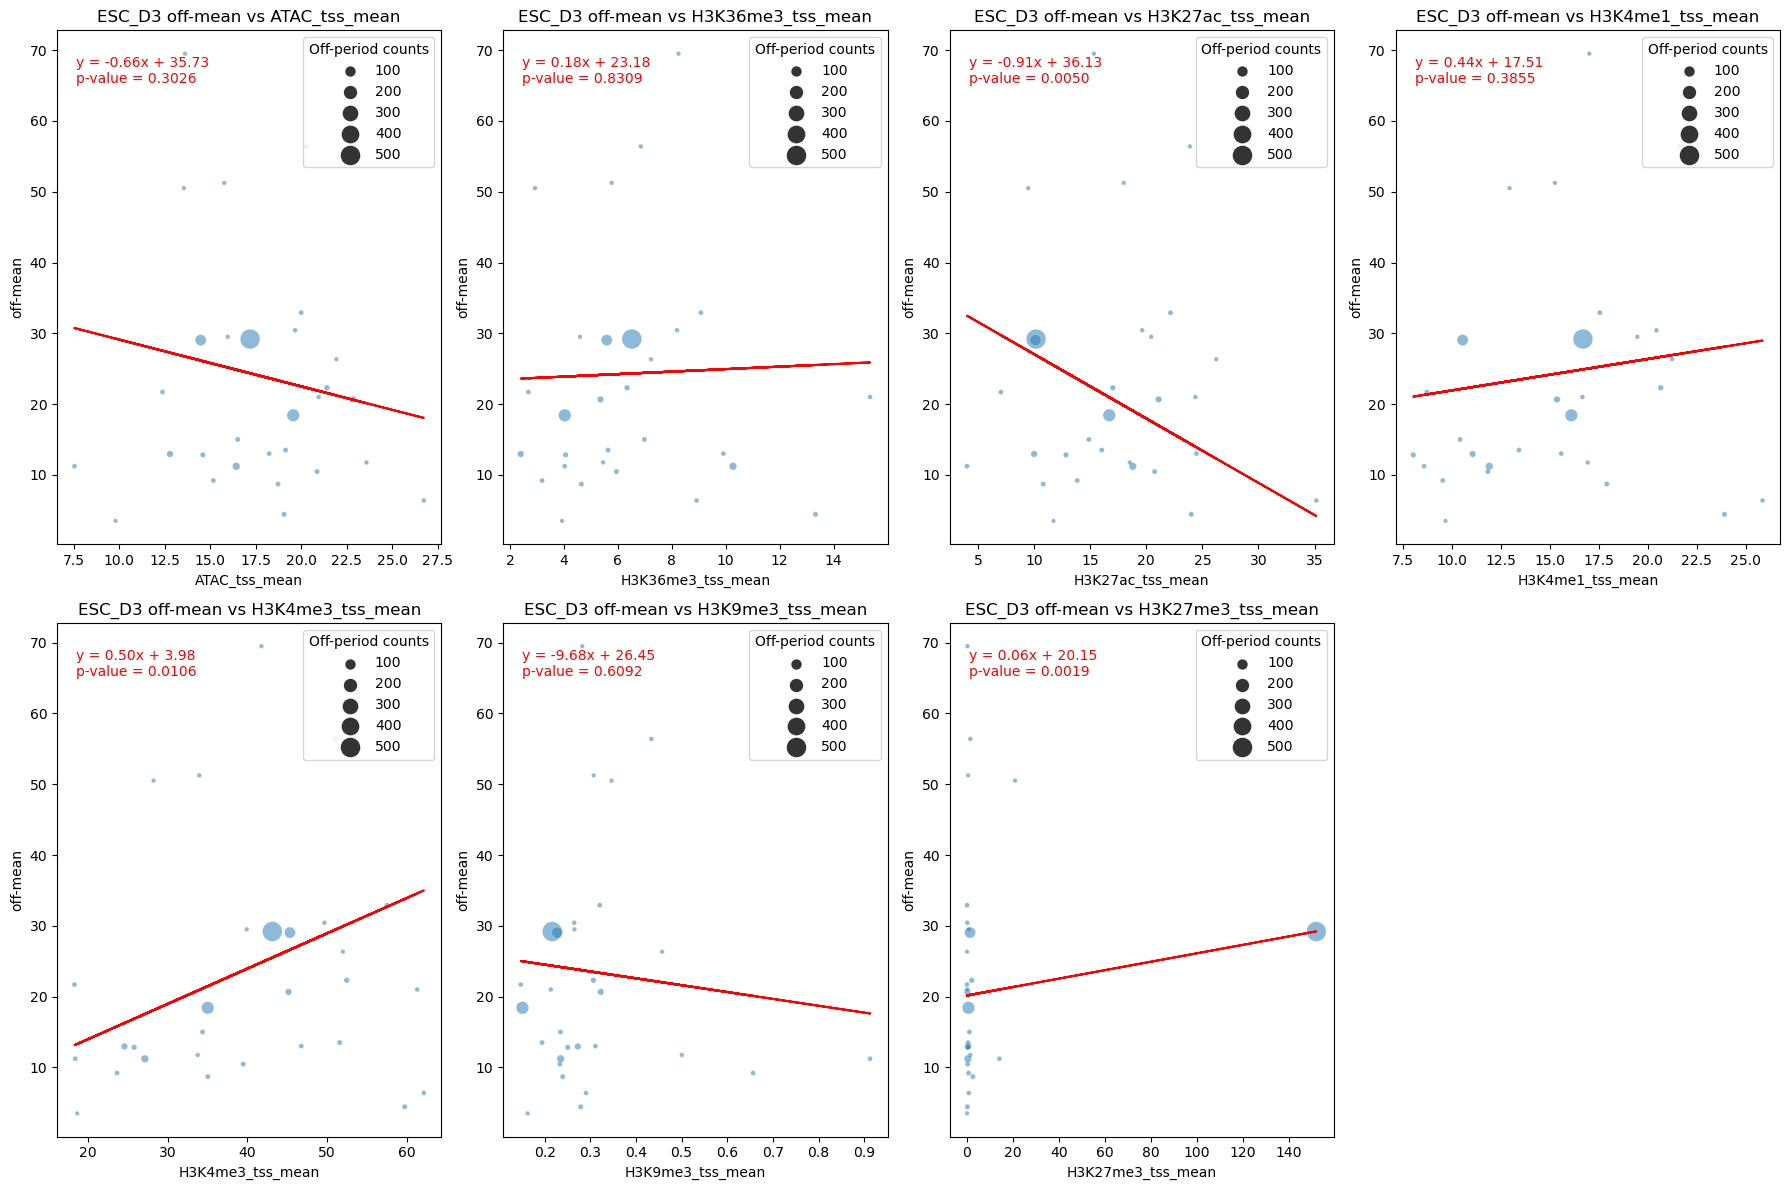

In [46]:

# Define the columns for plotting
columns = ['ATAC_tss_mean',
           'H3K36me3_tss_mean',
           'H3K27ac_tss_mean',
           'H3K4me1_tss_mean',
           'H3K4me3_tss_mean', 
           'H3K9me3_tss_mean',
           'H3K27me3_tss_mean',
          ]

plt.figure(figsize=(18, 12))
model_info = []
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(2, 4, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    # Annotate with regression equation and p-value
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{celltype} {y_col} vs {x_col}')

    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')
    
    print(col, f'{m:.2f}  {p:.4f}')
    model_info.append(f'{m:.2f}')
    model_info.append(f'{p:.4f}')
print(' '.join(map(str, model_info)))
plt.tight_layout()
plt.show()


H3K36me3_genebody_mean -0.65  0.0689
ATAC_genebody_mean 1.67  0.0045
H3K27ac_genebody_mean 3.08  0.0146
H3K4me1_genebody_mean 1.72  0.0013
H3K4me3_genebody_mean 0.57  2.938e-04
H3K9me3_genebody_mean -2.47  0.8771
H3K27me3_genebody_mean 0.09  0.0020
-0.65 0.0689 1.67 0.0045 3.08 0.0146 1.72 0.0013 0.57 2.938e-04 -2.47 0.8771 0.09 0.0020


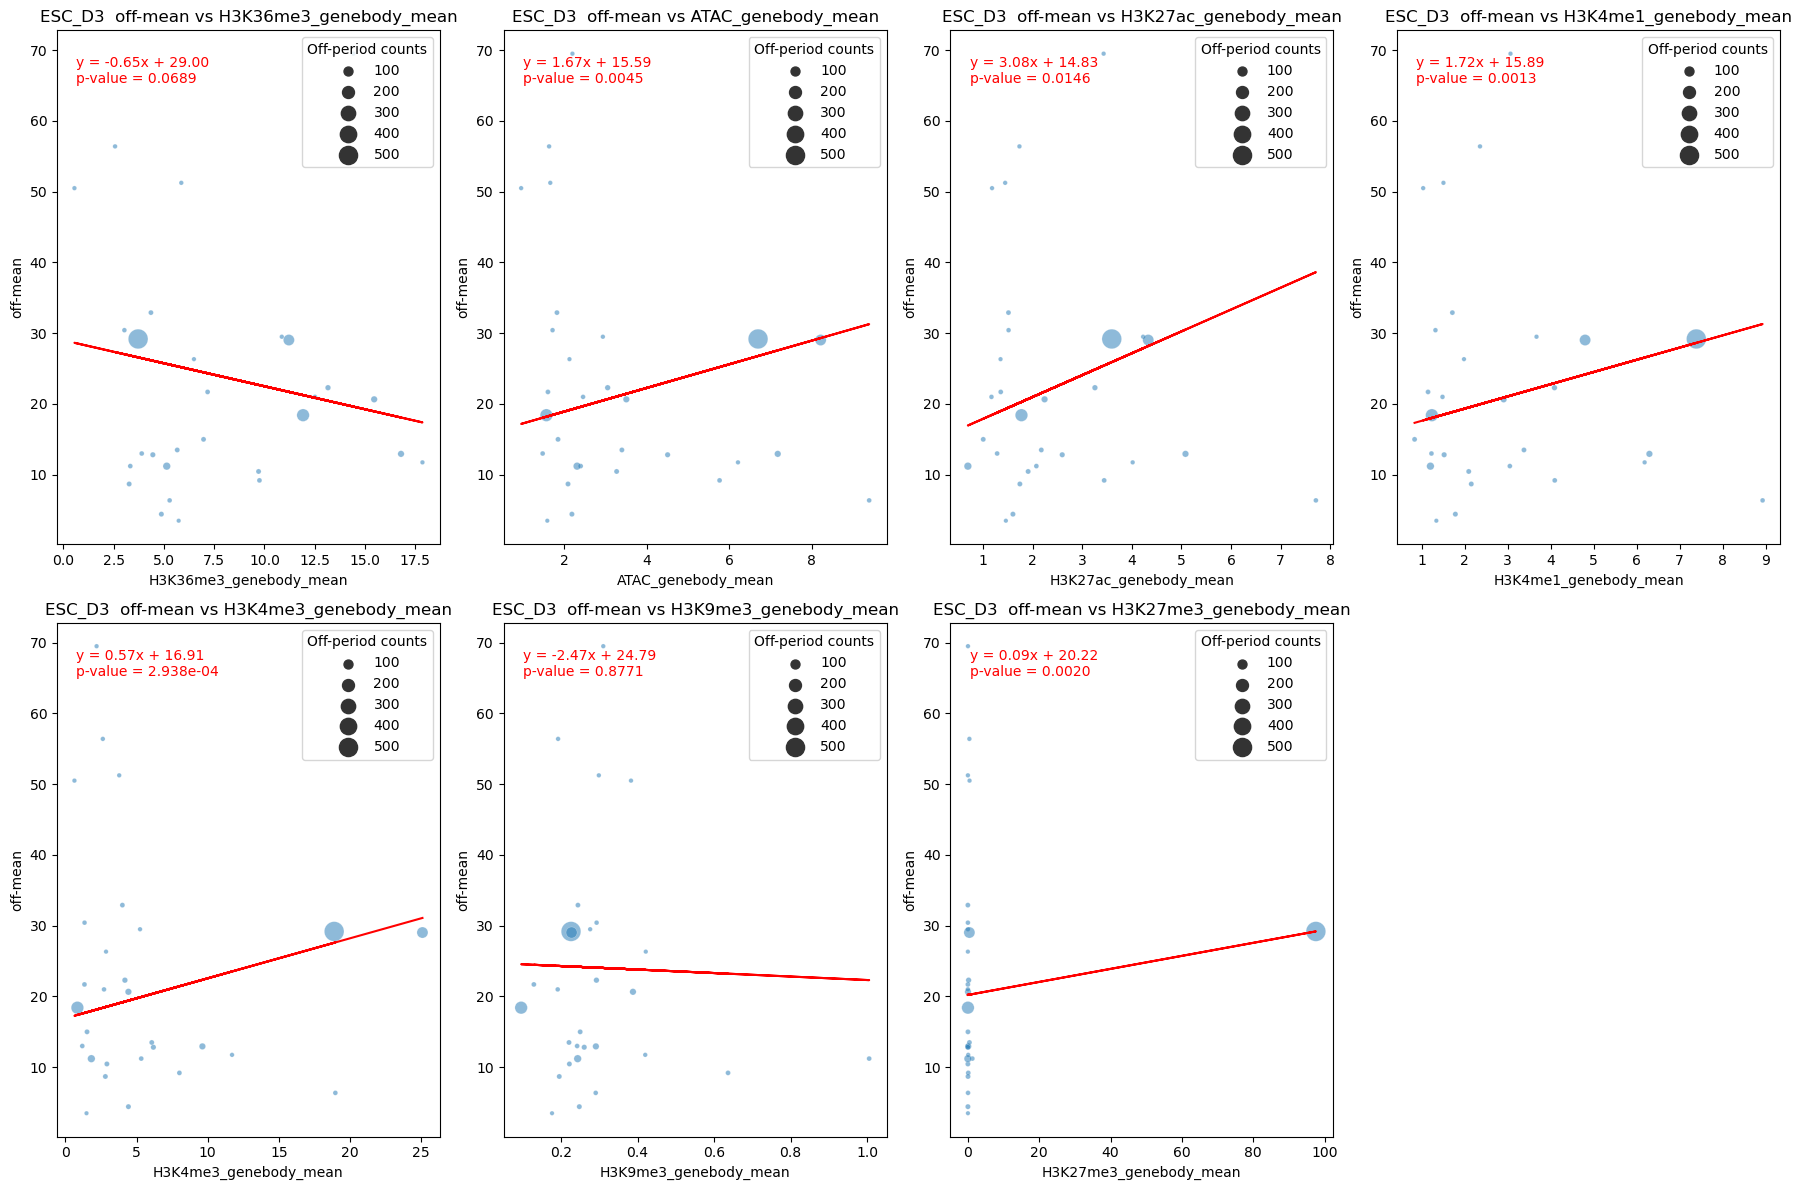

In [47]:

# Define the columns for plotting
columns = [
           'H3K36me3_genebody_mean',
           
            'ATAC_genebody_mean',
           'H3K27ac_genebody_mean',
           'H3K4me1_genebody_mean',
           'H3K4me3_genebody_mean', 
           'H3K9me3_genebody_mean',
           'H3K27me3_genebody_mean',
          ]

model_info = []
plt.figure(figsize=(18, 12))
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(2, 4, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    p = f'{p:.3e}' if p < 0.001 else f'{p:.4f}'
    
    ax.plot(x, m*x + b, color='red')
    
    # Annotate with regression equation and p-value
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{celltype}  {y_col} vs {x_col}')

    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')

    print(col, f'{m:.2f}  {p}')
    model_info.append(f'{m:.2f}')
    model_info.append(p)
print(' '.join(map(str, model_info)))
plt.tight_layout()
plt.show()


# compare 2 HEBC

In [16]:


data1 = df[df["celltype"]=="HBEC"]
data1.shape

(41, 43)

In [17]:
data2 = pd.read_csv("~/projects/transcriptome_4D/data/wanlab/version4/nonempty_gene_onoff.csv")
data2.columns = ['gene', 'off-period', 'on-period', 'off-mean', 'on-mean', 'K-off-rate', 'K-on-rate', 'off-median', 'on-median']
data2["gene"] = data2["gene"].str.replace('#', '', regex=True).apply(lambda x: x.split("~")[-1])


In [18]:
data3 = pd.merge(data1[["gene", "off-mean"]], data2[["gene", "off-mean"]], on="gene", suffixes=("_20240501", "_version4"))
data3.shape

(44, 3)

In [19]:
data3.head()

,gene,off-mean_20240501,off-mean_version4
0,LUZP1,79.750000,102.333333
1,CELF1,24.357143,75.333333
2,MIR222HG,42.727273,41.545455
3,B3GNT5,15.066667,15.333333
4,SAP30BP,34.529412,43.461538


In [20]:
data3.columns

Index(['gene', 'off-mean_20240501', 'off-mean_version4'], dtype='object')

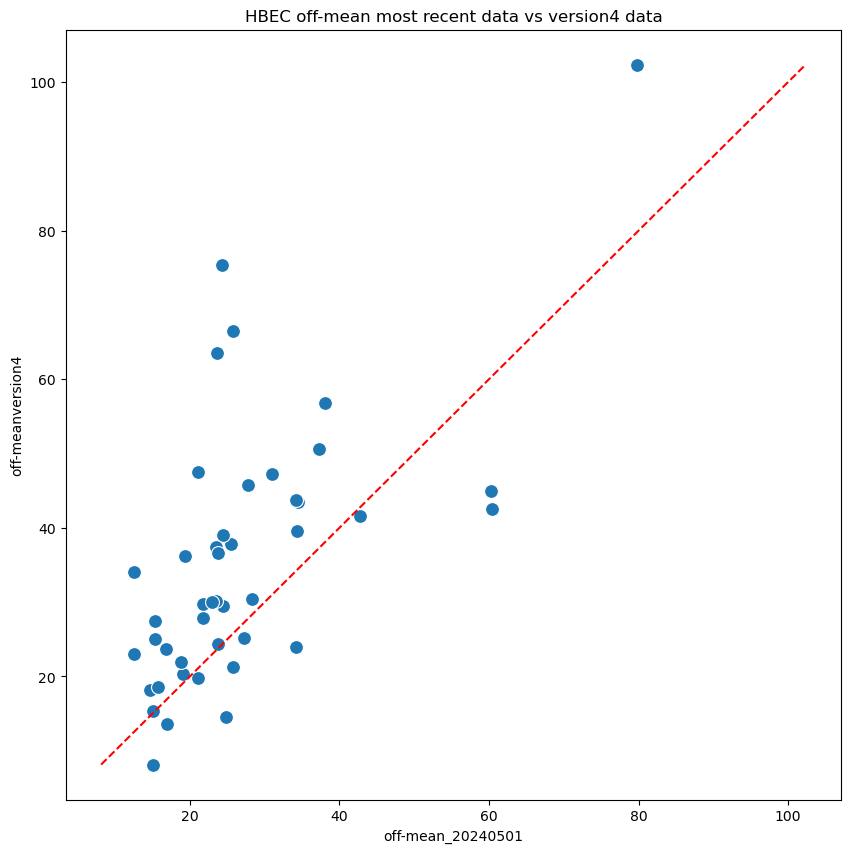

In [21]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='off-mean_20240501', y='off-mean_version4', data=data3, s=100)
plt.title('HBEC off-mean most recent data vs version4 data')
plt.xlabel('off-mean_20240501')
plt.ylabel('off-meanversion4')

# Adding the diagonal line
max_val = max(data3['off-mean_20240501'].max(), data3['off-mean_version4'].max())
min_val = min(data3['off-mean_20240501'].min(), data3['off-mean_version4'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


plt.show()